In [1]:
import numpy as np
import tensorflow as tf
from random import randint
import scipy as scipy
import scipy.interpolate as interpolate
import math
from random import *
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from scipy.stats import logistic
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt2
import pandas as pd

import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.plot


Lambda = 10.0
BATCH_SIZE = 30
BATCH_SIZE_2 = 100
number_of_neurons = 200
dimensionality = 13
num_epochs = 20
num_iters = 60
M = 30000
k=2
max_grad_norm = 1000
gamma = 1.0
epsilon = 0.8

/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
heart = pd.read_csv('/home/rust/Desktop/SDR/heart.csv')
X = heart.iloc[:,:-1].values
y = heart.iloc[:,13].values
print(len(y))
data = []
target = []
rr = np.random.permutation(303)
for x in rr:
    data.append(X[x])
    target.append(y[x])
# training data
_train_x = np.array(data)
_train_y = np.array(target)
print(_train_x.shape)
print(_train_y.shape)

303
(303, 13)
(303,)


In [3]:
new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
batch_size = tf.placeholder(tf.int32, shape=[], name="batch_size")
 
tf_data_x = tf.placeholder(tf.float32, shape=(None,dimensionality)) # узел на который будем подавать аргументы функции
tf_data_y = tf.placeholder(tf.float32, shape=(None,1)) # узел на который будем подавать значения функции

tf_data_w = tf.placeholder(tf.float32, shape=(number_of_neurons,1))
tf_data_B = tf.placeholder(tf.float32, shape=(dimensionality, number_of_neurons))
tf_data_biases = tf.placeholder(tf.float32, shape=(number_of_neurons))
tf_data_P = tf.placeholder(tf.float32, shape=(dimensionality, dimensionality))

tf_data_second = gamma*tf.random_normal([BATCH_SIZE_2, dimensionality])
Lbd = tf.placeholder(tf.float32, shape=[], name="lambda")

w = tf.Variable(tf.random_normal([number_of_neurons,1], stddev=0.35), name="neuron_weights")
B = tf.Variable(tf.random_normal([dimensionality, number_of_neurons], stddev=0.35), name="weights")
biases = tf.Variable(tf.zeros([number_of_neurons]), name="biases")

noise = epsilon*tf.random_normal([batch_size,dimensionality])
logits = tf.matmul(tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_x+noise, B), biases)), w)
out_loss = -tf.reduce_mean(tf.multiply(logits, tf_data_y)) + tf.reduce_mean(tf.math.log(1.0+tf.math.exp(logits)))

sigma_prime = tf.multiply(1.0 - tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, B), biases)), 
                       tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, B), biases)))
multiply = tf.stack([BATCH_SIZE_2, 1]) 
w_M_times = tf.tile(tf.transpose(w), multiply)
grad_psi = tf.matmul(tf.multiply(w_M_times, sigma_prime), tf.transpose(B))

new_part = grad_psi

tf_data_sigma_prime = tf.multiply(1.0 - tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, tf_data_B), tf_data_biases)), 
                       tf.nn.sigmoid(tf.nn.bias_add(tf.matmul(tf_data_second, tf_data_B), tf_data_biases)))
tf_data_w_M_times = tf.tile(tf.transpose(tf_data_w), multiply)
tf_data_grad_psi = tf.matmul(tf.multiply(tf_data_w_M_times, tf_data_sigma_prime), tf.transpose(tf_data_B))

old_part = tf.matmul(tf_data_grad_psi, tf_data_P)

loss2 = out_loss + Lbd*tf.reduce_mean(tf.square(tf.subtract(new_part, old_part)))
loss = 1000*loss2

In [4]:
target = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(loss)

In [5]:
def sigmoid(x):
  return 1. /(1+np.exp(-x))

Current part is 0

Epoch 0
Iter 69: loss: 1787.8772 log-likelihood: 1.0988

[191.91447826   9.26760832   7.13205081   6.24053284   5.95143923
   5.57182901   5.1004032    4.50986116   3.96946264   3.91646201
   3.08513391   2.76906369   2.70048751]
iter 1	train cost	1787.877197265625	log-likelihood	1.098825454711914	total variance to retain	0.006945532867700499
Epoch 1
Iter 138: loss: 929.7689 log-likelihood: 0.8387

[195.5634816    9.23761718   7.14216519   6.29979487   5.86319719
   5.64230692   5.13129843   4.48830118   3.99882696   3.84058153
   3.09050269   2.77146052   2.67890425]
iter 2	train cost	929.7688598632812	log-likelihood	0.8387492895126343	total variance to retain	0.006699720269500609
Epoch 2
Iter 207: loss: 730.2328 log-likelihood: 0.6398

[199.89289088   9.1380166    7.21300694   6.2803312    5.85837479
   5.66509991   5.08281403   4.44551069   4.02615509   3.72634528
   3.07161276   2.77933943   2.64897198]
iter 3	train cost	730.2327880859375	log-likelihood	0.6398065

/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


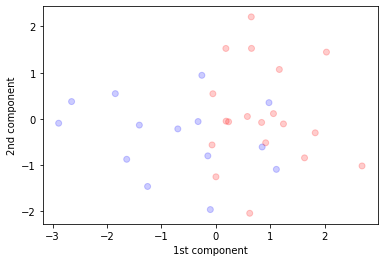

[[ 1.02203265e-01 -7.43754348e-03 -8.23658744e-02  1.45292905e-01
   6.95449724e-03  1.15669865e-01  3.24154608e-02 -8.44344152e-02
   1.18364917e-01  1.51468302e-01  3.93208352e-03  7.23329734e-02
   1.99320322e-04]
 [-7.43754348e-03  7.37515847e-02 -6.67755900e-02 -1.22858957e-01
  -5.36745403e-02 -5.04406235e-02 -4.35630730e-03 -5.54263665e-02
   6.37387235e-02 -2.12308079e-02 -7.14990479e-02  5.26726816e-02
   1.66695828e-01]
 [-8.23658744e-02 -6.67755900e-02  1.38710236e-01 -5.48232887e-03
   4.72436622e-02 -5.14485828e-02 -2.41383627e-02  1.29246016e-01
  -1.67307327e-01 -1.11922014e-01  6.76152389e-02 -1.15880984e-01
  -1.65867170e-01]
 [ 1.45292905e-01 -1.22858957e-01 -5.48232887e-03  3.78766605e-01
   9.14331852e-02  2.28889648e-01  4.91454981e-02 -2.55988727e-02
   5.72986172e-02  2.30985089e-01  1.14812018e-01  1.39694986e-02
  -2.55407100e-01]
 [ 6.95449724e-03 -5.36745403e-02  4.72436622e-02  9.14331852e-02
   3.90864007e-02  3.83897870e-02  3.65630663e-03  3.89699431e-02


iter 36	train cost	553.5143432617188	log-likelihood	0.4962223470211029	total variance to retain	0.003469251131281492
Epoch 16
Iter 1173: loss: 528.8733 log-likelihood: 0.4722

[214.84781255   6.25832164   5.35455668   4.66860031   4.22207918
   4.09483095   3.97031315   3.72251039   3.18373246   2.84872701
   2.75162073   2.30533765   2.12802989]
iter 37	train cost	528.873291015625	log-likelihood	0.4721542000770569	total variance to retain	0.003243797378211788
Epoch 17
Iter 1242: loss: 512.3369 log-likelihood: 0.4556

[218.14102104   6.27113852   5.32977258   4.67383176   4.19597961
   4.02372364   3.88903312   3.6449493    3.12266482   2.86831578
   2.72375498   2.2966572    2.13231855]
iter 38	train cost	512.3369140625	log-likelihood	0.45559602975845337	total variance to retain	0.003091245205625426
Epoch 18
Iter 1311: loss: 535.1782 log-likelihood: 0.4783

[222.9882022    6.29219793   5.2512423    4.69644379   4.18358604
   4.02318303   3.91539513   3.63802767   3.10380477   2.834061

/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


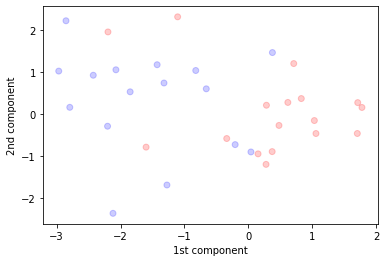

[[ 0.0173626   0.02944592 -0.03720282  0.03053861  0.03271942  0.02207468
  -0.00334447 -0.08619322  0.0505402  -0.01398682 -0.02142266  0.005831
   0.04045051]
 [ 0.02944592  0.10431746 -0.12098283  0.04494197  0.09314118  0.00231033
  -0.02113748 -0.09766804  0.02258844  0.08353389 -0.08601338  0.14969918
   0.14124052]
 [-0.03720282 -0.12098283  0.14134025 -0.05814322 -0.11018924 -0.00990495
   0.02362994  0.13304429 -0.04109305 -0.08420841  0.09879109 -0.16132894
  -0.16400097]
 [ 0.03053861  0.04494197 -0.05814322  0.05457632  0.0528067   0.0432512
  -0.00393444 -0.15771335  0.09684506 -0.03811102 -0.03142172 -0.00735474
   0.06199758]
 [ 0.03271942  0.09314118 -0.11018924  0.0528067   0.08772789  0.0172779
  -0.01701059 -0.12884131  0.0515354   0.04790343 -0.07476934  0.10779048
   0.12652194]
 [ 0.02207468  0.00231033 -0.00990495  0.0432512   0.0172779   0.05075643
   0.00573804 -0.14092149  0.10503283 -0.08706568  0.00485621 -0.08289921
   0.00450615]
 [-0.00334447 -0.02113748 

[205.7100519    6.72417192   6.18787997   4.88864687   4.6067745
   4.41350281   4.10075726   3.97690629   3.6646814    3.44093496
   3.04170028   2.80126366   2.15058985]
iter 59	train cost	565.3018188476562	log-likelihood	0.4995592534542084	total variance to retain	0.004290018570692444
Epoch 19
Iter 1380: loss: 545.9275 log-likelihood: 0.4787

[208.23714834   6.63598191   5.95388691   4.77006073   4.50376317
   4.36205341   4.00998949   3.92161776   3.61973551   3.42165523
   2.97169872   2.74976484   2.09140061]
iter 60	train cost	545.927490234375	log-likelihood	0.478680282831192	total variance to retain	0.0040051381578101175
Part 2: error on test 0.8182



/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


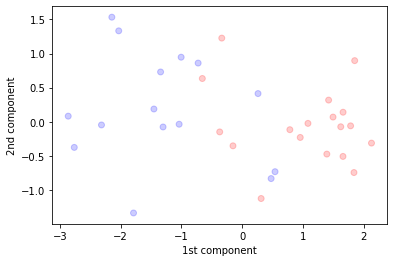

[[ 0.08629112  0.04472582 -0.09912835  0.05462598  0.01546822  0.02311422
   0.11612915 -0.0134833   0.14273968  0.01910154 -0.14149046  0.07115167
   0.06141033]
 [ 0.04472582  0.03842277 -0.0686556   0.00477296 -0.01357075  0.01255305
   0.00384317 -0.08854504  0.05891418 -0.01718783 -0.0917598   0.07061201
   0.06957534]
 [-0.09912835 -0.0686556   0.13345849 -0.03606845  0.00670169 -0.02720196
  -0.06953233  0.10793688 -0.14689246  0.00876266  0.18342325 -0.11997463
  -0.11333233]
 [ 0.05462598  0.00477296 -0.03606845  0.0709403   0.04313635  0.0137478
   0.16054807  0.11743384  0.11363643  0.05393193 -0.06111331 -0.00706104
  -0.01942515]
 [ 0.01546822 -0.01357075  0.00670169  0.04313635  0.03335174  0.00333223
   0.1006323   0.1131054   0.04693272  0.04179401  0.00073322 -0.03502766
  -0.04245731]
 [ 0.02311422  0.01255305 -0.02720196  0.0137478   0.00333223  0.00621296
   0.02898954 -0.00667603  0.03766849  0.0040988  -0.03859232  0.02032639
   0.0178678 ]
 [ 0.11612915  0.003843

Iter 1311: loss: 524.9601 log-likelihood: 0.4688

[235.19710864   6.5316133    4.99852634   4.36575104   4.18715983
   3.81078736   3.60146484   3.200221     3.15805945   2.8656586
   2.74274268   2.60749952   2.11433037]
iter 79	train cost	524.9600830078125	log-likelihood	0.4688356816768646	total variance to retain	0.002455803891733832
Epoch 19
Iter 1380: loss: 479.3812 log-likelihood: 0.4250

[235.98222312   6.47482151   4.92167744   4.2679748    4.12035774
   3.7555673    3.53821434   3.18575257   3.15561766   2.88957511
   2.70728654   2.57674007   2.10302355]
iter 80	train cost	479.3811950683594	log-likelihood	0.4249986410140991	total variance to retain	0.002378833494496524
Part 3: error on test 0.7879



/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


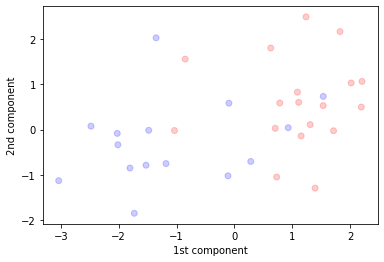

[[ 0.39720322 -0.15619377 -0.20782101 -0.04424449 -0.0427378  -0.07183513
   0.20520624  0.07909945  0.10903568  0.18223696  0.14512483  0.20961989
   0.06659764]
 [-0.15619377  0.24537599 -0.0286693   0.00927109  0.01016398  0.09873905
  -0.18866058 -0.13274897  0.11274355  0.10146009 -0.26517824 -0.00403267
   0.05876571]
 [-0.20782101 -0.0286693   0.17498016  0.02802641  0.02634673 -0.00471676
  -0.04257541  0.0196111  -0.15043624 -0.19923875  0.04895606 -0.15672141
  -0.08582559]
 [-0.04424449  0.00927109  0.02802641  0.00528747  0.00505402  0.00488735
  -0.01808786 -0.00432013 -0.01902095 -0.0279481  -0.00697093 -0.02681324
  -0.01117168]
 [-0.0427378   0.01016398  0.02634673  0.00505402  0.00483827  0.00518405
  -0.01818125 -0.00484083 -0.01735078 -0.02585894 -0.00810085 -0.02538507
  -0.01023309]
 [-0.07183513  0.09873905 -0.00471676  0.00488735  0.00518405  0.04000348
  -0.07848443 -0.0532551   0.03991372  0.03338172 -0.1059933  -0.00786879
   0.0205098 ]
 [ 0.20520624 -0.18866

Iter 1311: loss: 493.7394 log-likelihood: 0.4216

[281.0181719    8.38115562   6.76763313   6.44579633   4.82341736
   4.69944439   4.13644223   4.06095003   3.62065504   3.37637407
   3.14486158   2.97222663   2.48681793]
iter 99	train cost	493.7394104003906	log-likelihood	0.42158544063568115	total variance to retain	0.002721751616201473
Epoch 19
Iter 1380: loss: 501.8172 log-likelihood: 0.4310

[280.64039676   8.43015256   6.59495164   6.27555952   4.74683908
   4.64726998   4.08274215   3.9657156    3.57352732   3.30962386
   3.11067758   2.9049492    2.45554183]
iter 100	train cost	501.8171691894531	log-likelihood	0.43098199367523193	total variance to retain	0.002622427303159869
Part 4: error on test 0.7273



/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


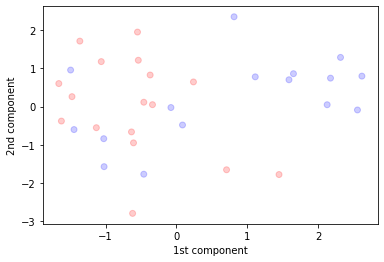

[[ 0.21962419 -0.08884407  0.04540776  0.06788684 -0.12283485  0.20785401
   0.04950119  0.00639591 -0.09352747 -0.17799328 -0.08027776  0.16214901
  -0.15125102]
 [-0.08884407  0.12969589 -0.12354804  0.05395172  0.05902461 -0.05147075
   0.00201337 -0.12182053  0.13000153  0.14235184 -0.06990521  0.08624724
   0.12782597]
 [ 0.04540776 -0.12354804  0.12738268 -0.07729765 -0.03586819  0.00638881
  -0.01448863  0.1350831  -0.12273383 -0.11572047  0.09825628 -0.13681687
  -0.10603179]
 [ 0.06788684  0.05395172 -0.07729765  0.09168053 -0.02986311  0.09256749
   0.0344379  -0.10156018  0.05112431  0.0060693  -0.1137166   0.18197345
   0.01111568]
 [-0.12283485  0.05902461 -0.03586819 -0.02986311  0.06963035 -0.11300494
  -0.02549166 -0.01544826  0.06148582  0.10655489  0.0347059  -0.07557168
   0.0912289 ]
 [ 0.20785401 -0.05147075  0.00638881  0.09256749 -0.11300494  0.20805831
   0.05451396 -0.03542077 -0.05645585 -0.14398422 -0.11158713  0.20627521
  -0.1199649 ]
 [ 0.04950119  0.00201

Iter 1311: loss: 503.6089 log-likelihood: 0.4427

[228.12473365   8.58023245   5.62011964   5.25020612   4.7596495
   3.65662365   3.45439725   3.20911694   3.16209145   2.98634485
   2.7248603    2.34555683   2.08920841]
iter 119	train cost	503.60888671875	log-likelihood	0.44274112582206726	total variance to retain	0.0029389846494753957
Epoch 19
Iter 1380: loss: 529.1741 log-likelihood: 0.4707

[230.7649561    8.62835329   5.63114039   5.24973834   4.76050272
   3.64234415   3.41390935   3.20660516   3.1670755    2.95154696
   2.7390553    2.3492504    2.07264232]
iter 120	train cost	529.1741333007812	log-likelihood	0.47065603733062744	total variance to retain	0.0028645209324467125
Part 5: error on test 0.8788



/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


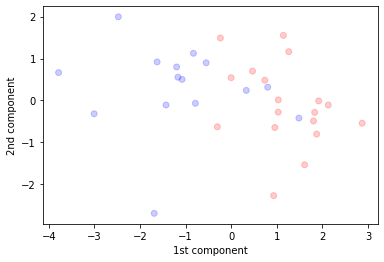

[[ 5.26666049e-02  2.24924743e-02 -2.78854390e-02 -3.06422768e-02
   1.97264432e-02  3.02032934e-02  3.42654938e-02 -6.65616666e-02
   4.17157577e-02  1.60976928e-01 -7.81023918e-02  6.54044913e-04
   8.37271590e-02]
 [ 2.24924743e-02  2.39554003e-01 -1.72986299e-01 -6.82761047e-02
   9.59383996e-02 -8.68606376e-02 -1.55087365e-01 -5.55416052e-03
   1.71636789e-01  2.28097463e-04 -4.82944997e-02  2.69575158e-01
   4.22117890e-02]
 [-2.78854390e-02 -1.72986299e-01  1.27598089e-01  5.48841800e-02
  -7.17474275e-02  5.38892361e-02  1.00746068e-01  1.92204165e-02
  -1.29838015e-01 -3.72342430e-02  5.18176907e-02 -1.88986339e-01
  -4.88522254e-02]
 [-3.06422768e-02 -6.82761047e-02  5.48841800e-02  3.10741780e-02
  -3.24812596e-02  6.37045655e-03  2.07984166e-02  3.32370357e-02
  -6.11893609e-02 -7.72133574e-02  4.90267438e-02 -6.50139730e-02
  -5.02628718e-02]
 [ 1.97264432e-02  9.59383996e-02 -7.17474275e-02 -3.24812596e-02
   4.06946434e-02 -2.66538433e-02 -5.17583526e-02 -1.62260469e-02


Iter 1173: loss: 512.7399 log-likelihood: 0.4648

[210.53314599   5.73464063   4.55348682   4.36086045   4.00755155
   3.65618839   3.4863842    3.2536186    2.7786654    2.63559683
   2.44644454   2.30968524   1.82794597]
iter 137	train cost	512.7399291992188	log-likelihood	0.4647919237613678	total variance to retain	0.002726021510853993
Epoch 17
Iter 1242: loss: 522.3618 log-likelihood: 0.4758

[213.47411082   5.70330771   4.52351102   4.37504016   3.96923612
   3.65098584   3.44601008   3.26184874   2.71715308   2.63045515
   2.41987423   2.26965148   1.85243609]
iter 138	train cost	522.36181640625	log-likelihood	0.47581952810287476	total variance to retain	0.002623218040383679
Epoch 18
Iter 1311: loss: 521.0330 log-likelihood: 0.4733

[216.59151166   5.84751538   4.48169965   4.30785594   3.93699616
   3.61990952   3.45636501   3.21002473   2.69689777   2.64222355
   2.40114492   2.26798155   1.84268479]
iter 139	train cost	521.032958984375	log-likelihood	0.47331640124320984	total 

/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


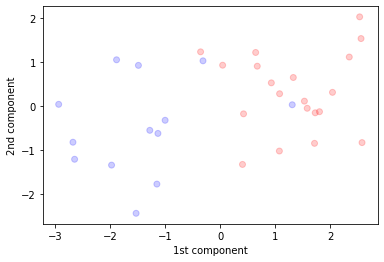

[[ 7.58673652e-02  1.35827386e-01  5.72861533e-02 -8.04871470e-02
  -1.39742810e-02 -4.89985455e-02 -1.13398550e-02 -9.63962223e-02
   6.15279676e-02  8.96307141e-02 -8.98847701e-02  5.48717319e-02
   8.35227439e-02]
 [ 1.35827386e-01  2.58106158e-01  1.77089457e-01 -2.01042736e-01
  -4.14223165e-02 -9.71454739e-02 -1.31583349e-02 -1.45151004e-01
   6.38107765e-02  1.45199098e-01 -1.55549110e-01  5.46540774e-02
   1.28558309e-01]
 [ 5.72861533e-02  1.77089457e-01  4.15273621e-01 -3.45019279e-01
  -9.24331589e-02 -8.40292804e-02  2.70961484e-02  6.41316547e-02
  -1.84874787e-01 -8.53928784e-03 -4.10454441e-02 -1.76123240e-01
  -4.16311083e-02]
 [-8.04871470e-02 -2.01042736e-01 -3.45019279e-01  3.02568991e-01
   7.73877223e-02  8.79170636e-02 -1.52150825e-02 -2.34843122e-03
   1.11478636e-01 -3.68533506e-02  7.48621301e-02  1.08013277e-01
  -8.61310883e-03]
 [-1.39742810e-02 -4.14223165e-02 -9.24331589e-02  7.73877223e-02
   2.05961376e-02  1.93768467e-02 -5.75977518e-03 -1.23803713e-02


Iter 1173: loss: 503.2132 log-likelihood: 0.4385

[233.44997758   7.1565869    6.00705847   5.39096535   5.0913082
   4.7779047    3.64768547   3.48656327   3.27349868   2.98649792
   2.84594336   2.44110801   2.2486796 ]
iter 157	train cost	503.2131652832031	log-likelihood	0.43850672245025635	total variance to retain	0.003254421896364046
Epoch 17
Iter 1242: loss: 524.5601 log-likelihood: 0.4605

[234.29078327   7.19148088   5.93141622   5.30255736   5.02309907
   4.77280878   3.63039815   3.4865143    3.26342013   2.97790977
   2.85511191   2.44055167   2.24359409]
iter 158	train cost	524.5601196289062	log-likelihood	0.4605233371257782	total variance to retain	0.003180473629944225
Epoch 18
Iter 1311: loss: 527.8508 log-likelihood: 0.4665

[236.24087522   7.10071574   5.92016085   5.30226372   4.93815597
   4.66505701   3.58579939   3.42188597   3.24481145   2.91897413
   2.7980191    2.41756646   2.20952009]
iter 159	train cost	527.850830078125	log-likelihood	0.4665498733520508	total 

/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


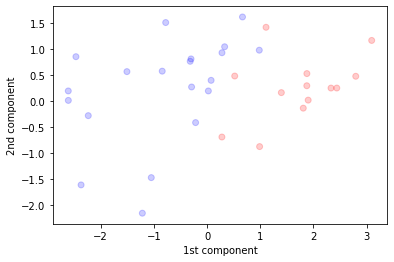

[[ 8.14284727e-02  6.98286664e-02 -1.63278626e-01 -3.81155074e-02
  -5.53207585e-02 -2.82660188e-02  2.02354942e-02 -1.19814034e-01
  -3.39059820e-02  1.15522937e-01 -2.34062633e-03  3.85426684e-03
   9.31096221e-02]
 [ 6.98286664e-02  1.25517961e-01 -1.43309998e-01  8.08880469e-02
  -4.32187147e-03 -2.24779649e-02 -7.60379977e-02 -1.26970209e-01
   7.14891831e-02  1.30334274e-01  1.13989916e-02  1.64469498e-01
   7.81121023e-02]
 [-1.63278626e-01 -1.43309998e-01  3.27567813e-01  7.07337493e-02
   1.08766029e-01  5.65900944e-02 -3.58931153e-02  2.41463140e-01
   6.29451633e-02 -2.33211909e-01  4.02118097e-03 -1.58093490e-02
  -1.86614488e-01]
 [-3.81155074e-02  8.08880469e-02  7.07337493e-02  2.14362887e-01
   1.00504122e-01  1.62788277e-02 -1.71070050e-01  1.41671752e-02
   1.89882929e-01  2.97415984e-05  2.42928965e-02  2.77065147e-01
  -4.65831591e-02]
 [-5.53207585e-02 -4.32187147e-03  1.08766029e-01  1.00504122e-01
   6.59090886e-02  2.03604628e-02 -7.50981603e-02  6.54856825e-02


Iter 1173: loss: 547.7686 log-likelihood: 0.4766

[247.81740641   9.16542614   7.19414168   5.6674209    5.35692387
   4.54264142   4.07688942   4.01653477   3.88688967   3.58277516
   3.05062896   2.72443692   2.28855777]
iter 177	train cost	547.7685546875	log-likelihood	0.47655677795410156	total variance to retain	0.0034979747329747513
Epoch 17
Iter 1242: loss: 523.9630 log-likelihood: 0.4512

[248.59659734   9.14444208   7.10559219   5.58329712   5.3132165
   4.45652217   4.04386783   3.93626634   3.83134008   3.54211105
   3.02379699   2.69570245   2.249146  ]
iter 178	train cost	523.9629516601562	log-likelihood	0.4511526823043823	total variance to retain	0.0033867117239139155
Epoch 18
Iter 1311: loss: 495.4314 log-likelihood: 0.4237

[251.26160553   9.08880737   6.94913504   5.49991289   5.21167829
   4.4137521    3.9977282    3.92826403   3.79129477   3.51780739
   2.99928091   2.68370677   2.24413436]
iter 179	train cost	495.4314270019531	log-likelihood	0.42370980978012085	total

/home/rust/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


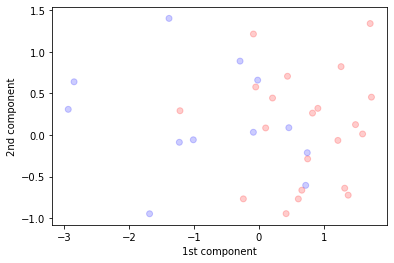

[[ 1.33941165e-01 -1.05294022e-01  7.78599529e-03  7.66481862e-02
  -1.43320461e-01  3.06053307e-03 -5.05963685e-02  6.18471620e-02
   1.29111092e-01 -1.59182842e-02 -9.09707764e-02  1.11026955e-02
   2.16151171e-01]
 [-1.05294022e-01  1.38770407e-01 -1.12496014e-01 -3.36444768e-02
   1.73297890e-01 -2.99458980e-02  1.56469816e-02 -1.56801457e-01
  -4.51376223e-02  5.84074449e-02  6.80176669e-02  1.19326312e-01
  -1.20683882e-01]
 [ 7.78599529e-03 -1.12496014e-01  2.02531224e-01 -4.60954195e-02
  -1.23509750e-01  5.24949024e-02  4.28940587e-02  2.09106134e-01
  -9.95593650e-02 -8.81085944e-02  1.35392251e-03 -2.42616510e-01
  -8.09698755e-02]
 [ 7.66481862e-02 -3.36444768e-02 -4.60954195e-02  5.65077061e-02
  -5.32030278e-02 -1.13359588e-02 -4.04198157e-02 -1.60173898e-02
   1.00666905e-01  1.27000484e-02 -5.37198096e-02  6.72067269e-02
   1.47091260e-01]
 [-1.43320461e-01  1.73297890e-01 -1.23509750e-01 -5.32030278e-02
   2.19004734e-01 -3.30939091e-02  2.80147509e-02 -1.83312901e-01


In [6]:
scores = []
for part in range(9):
    print("Current part is %d\n" % part)
    train_x = np.concatenate((_train_x[0:(part*33)], _train_x[(part+1)*33:303]), axis=0)
    train_y = np.concatenate((_train_y[0:(part*33)], _train_y[(part+1)*33:303]), axis=0)
    test_x = _train_x[part*33:(part+1)*33]
    test_y = _train_y[part*33:(part+1)*33]
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)

    cur_w = np.random.normal(0, 0.35, (number_of_neurons,1))
    cur_B =  np.random.normal(0, 0.35, (dimensionality, number_of_neurons))
    cur_biases = np.zeros((number_of_neurons))
    cur_P = np.zeros((dimensionality, dimensionality)) 
    O = np.zeros((dimensionality, k)) 
    cur_iter = 0
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for epoch in range(num_epochs):
        print("Epoch %d" %(epoch))
        for iteration in range(num_iters):
            offset = (cur_iter % 9)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            sess.run(target, feed_dict={tf_data_x: sample_x, tf_data_y: sample_y, 
                                  tf_data_w: cur_w, tf_data_B: cur_B, tf_data_biases: cur_biases,
                                  tf_data_P: cur_P, Lbd: Lambda, batch_size: BATCH_SIZE})
            cur_iter = cur_iter+1
        reses = []
        outes = []
        for i in range(9):
            offset = (cur_iter % 9)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            res, out = sess.run([loss, out_loss], feed_dict={tf_data_x: sample_x, tf_data_y: sample_y, 
                                  tf_data_w: cur_w, tf_data_B: cur_B, tf_data_biases: cur_biases,
                                  tf_data_P: cur_P, Lbd: Lambda, batch_size: BATCH_SIZE})
            reses.append(res)
            outes.append(out)
            cur_iter = cur_iter+1
        print ("Iter %d: loss: %.4f log-likelihood: %.4f\n" %(cur_iter, np.mean(np.array(reses)), np.mean(np.array(outes))))
        lib.plot.plot('train cost', np.mean(np.array(reses)))
        lib.plot.plot('log-likelihood', np.mean(np.array(outes)))

        cur_w, cur_B, cur_biases = sess.run([w, B, biases], feed_dict={})    
        third_x = np.random.normal(0, 0.35, (M,dimensionality))
        third_sigma_prime = np.multiply(1.0-logistic.cdf(np.add(np.matmul(third_x, cur_B), np.tile(np.reshape(cur_biases,[1, number_of_neurons]),(M,1)))), 
                           logistic.cdf(np.add(np.matmul(third_x, cur_B), np.tile(np.reshape(cur_biases,[1, number_of_neurons]),(M,1)))))
        third_w_M_times = np.tile(np.reshape(cur_w,[1, number_of_neurons]), (M,1))
        third_grad_psi = np.matmul(np.multiply(third_w_M_times, third_sigma_prime), np.transpose(cur_B))
        
        u, s, vh = np.linalg.svd(np.transpose(third_grad_psi), full_matrices=True)
        O = u[:,0:k:1]
        print(s)
        cur_P = np.matmul(O, np.transpose(O))
        tvr = 1-np.sum(np.multiply(s[0:k],s[0:k]))/np.sum(np.multiply(s,s))
        lib.plot.plot('total variance to retain', tvr)
        lib.plot.tick()
        lib.plot.flush()
    reduced_train_x = np.matmul(train_x, O)
    reduced_test_x = np.matmul(test_x, O)
    clf = LogisticRegression(random_state=0).fit(reduced_train_x, train_y)
    score = clf.score(reduced_test_x, test_y)
    scores.append(score)
    print ("Part %d: rate on test %.4f\n" %(part, score))
    test_rgb = []
    for h in test_y:
        if h == 1:
            test_rgb.append('r')
        else:
            test_rgb.append('b')
    plt2.close()
    plt2.scatter(np.transpose(reduced_test_x)[0], np.transpose(reduced_test_x)[1], alpha=0.2, c=np.array(test_rgb))
    plt2.xlabel("1st component")
    plt2.ylabel("2nd component")
    plt2.show()
    sess.close()
    print(cur_P)
print ("Average rate on test %.4f\n" %(np.mean(np.array(scores))))